In [1]:
# import packages 
import networkx as nx
import os
import pandas as pd
import tweepy
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import matplotlib as matplotlib
from pyvis import network as net
import pickle
from IPython.core.display import display, HTML


In [2]:
# paste where the final subset of your data can be found. 

path = "/Users/lukas/Documents/Uni/Copenhagen/Year 1/Block 4/ASDS II/Exam/github/ASDS2/Notebooks/data/"

df = pd.read_csv(path+ "bushfire_subset3.csv")
df.shape

(2988, 21)

In [3]:
# drop tweets that are not retweeted
df_retweet = df.dropna(subset=["retweet_name"])

In [4]:
df_retweet.shape

(1192, 21)

In [5]:
# code retweets as 1 if they are retweeted from a MP in the DF. else 0

df_retweet["retweetet"] = [1 if x in set(df_retweet["screen_name"]) else 0 for x in df_retweet["retweet_name"]]

<ipython-input-5-80864ae65f1e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_retweet["retweetet"] = [1 if x in set(df_retweet["screen_name"]) else 0 for x in df_retweet["retweet_name"]]


In [6]:
# sum of intra-df retweets 
df_retweet.retweetet.sum()

429

In [7]:
# delete retweets from non-mps

df_retweet = df_retweet[df_retweet["retweetet"]==1]

df_retweet.reset_index(inplace=True)

In [8]:
# group df and get counts of how often people retweeted each other (as weights)

df_rt = df_retweet.groupby(["screen_name", "retweet_name"]).size().reset_index(name='simple_count')

df_rt["count"] = df_rt["simple_count"]**0.6

print(df_rt.shape)
df_rt.head(5)

(173, 4)


,screen_name,retweet_name,simple_count,count
0,ALeighMP,AlboMP,1,1.0
1,ALeighMP,AliciaPayneMP,1,1.0
2,AlanTudgeMP,DarrenChesterMP,1,1.0
3,AlanTudgeMP,GregHuntMP,1,1.0
4,AlanTudgeMP,JoshFrydenberg,1,1.0


## Graph using networkx

# 1

Graph has 73 nodes with 173 edges


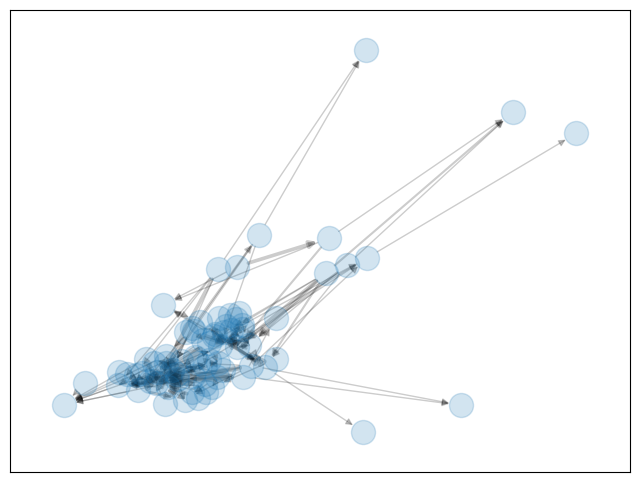

In [9]:


G = nx.from_pandas_edgelist(df_rt,
                            source = 'screen_name',
                            target = 'retweet_name',
                            edge_attr = "count",
                            create_using = nx.DiGraph())

pos = nx.spring_layout(G, k=0.3)

edge_w = [i['count'] for i in dict(G.edges).values()]

plt.rcParams.update(plt.rcParamsDefault)
plt.rcParams.update({'figure.figsize': (8, 6)})

nx.draw_networkx(G, edge_color="black",
                 with_labels=False,
                 alpha=0.2,
                 width=edge_w
                )

print(f"Graph has {nx.number_of_nodes(G)} nodes with {nx.number_of_edges(G)} edges")
plt.show()

## Network using PyVis

In [10]:
# create df with screen name and party
df_party = df_retweet.drop_duplicates("screen_name")

df_party.drop(['index', 'Unnamed: 0', 'user_id', 'tweet_id',
       'created_at', 'full_text', 'favorite_count', 'retweet_count',
       'retweet_name', 'in_reply_to_screen_name', 'hashtags', 'user_mentions',
       'url', 'image_url', 'name', 'legislative_period', 'stems',
       'stems_bigrams', 'final_text', 'index_col', 'retweetet'], axis=1, inplace=True)


/Users/lukas/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [11]:
# Create nodelist
a1 = df_rt["screen_name"].tolist()
a2 = df_rt["retweet_name"].tolist()
node_list = list(set(a1 + a2))

In [12]:
# create a df of the node list and the corresponding party

node_df = pd.DataFrame(node_list, columns= ["screen_name"])

node_df = node_df.merge(df_party, how='outer', on='screen_name')

print("Parties in node list:", "\n", node_df.party.unique())
print("-"*20, "\n", "-"*20)

node_dict = dict(zip(node_df.screen_name, node_df.party))

for i, y in node_dict.items():
    print("name:", i,"-"*5,"party:",y)

# manually add party membership for the those we didnt catch
node_dict["DarrenChesterMP"] = "The Nationals"
node_dict["Josh4Freo"] = 'Australian Labor Party'
node_dict["AliciaPayneMP"] = 'Australian Labor Party'
node_dict["fitzhunter"] = 'Australian Labor Party'
node_dict["billshortenmp"] = 'Australian Labor Party'
node_dict["DanTehanWannon"] = 'Liberal Party of Australia'

Parties in node list: 
 ['Australian Labor Party' nan 'Liberal Party of Australia'
 'Liberal National Party of Queensland' 'The Nationals']
-------------------- 
 --------------------
name: MRowlandMP ----- party: Australian Labor Party
name: DarrenChesterMP ----- party: nan
name: Tony_Burke ----- party: Australian Labor Party
name: CatherineKingMP ----- party: Australian Labor Party
name: tanya_plibersek ----- party: Australian Labor Party
name: AlanTudgeMP ----- party: Liberal Party of Australia
name: JasonClareMP ----- party: Australian Labor Party
name: MariaVamvakinou ----- party: Australian Labor Party
name: terrimbutler ----- party: Australian Labor Party
name: MThistlethwaite ----- party: Australian Labor Party
name: sussanley ----- party: Liberal Party of Australia
name: GregHuntMP ----- party: Liberal Party of Australia
name: Mark_Butler_MP ----- party: Australian Labor Party
name: JEChalmers ----- party: Australian Labor Party
name: JasonFalinskiMP ----- party: Liberal Party

In [28]:
# Edgedata as tuples
tuples = [tuple(x) for x in df_rt[["screen_name","retweet_name", "count"]].values]

# Create network
nt = net.Network(notebook=True,
                     height = "500px",
                     width = "800px",
                     #bgcolor = "#f6f2e9"
                     #directed=True
                )

# Add nodes and edges to network

for name, party in node_dict.items():
    if party == "Liberal Party of Australia":
        color = "blue"
        nt.add_node(name, title=name, color=color)
    elif party == "Australian Labor Party":
        color = "red"
        nt.add_node(name, title=name, color=color)
    elif party == "Liberal National Party of Queensland":
        color = "pink"
        nt.add_node(name, title=name, color=color)
    else: # The Nationals
        color = "yellow"
        nt.add_node(name, title=name, color=color)

nt.add_edges(tuples)

nt.force_atlas_2based(gravity=-50, central_gravity=0.01, spring_length=100, spring_strength=0.08, damping=0.4, overlap=0)

# Save and show
nt.show('retweet_network.html')

In [14]:
# get tweet id from the only tweet that connects the clusters for further netnography

burns_falinski = np.where((df_retweet['screen_name'] == "joshburnsmp") & (df_retweet['retweet_name'] == "JasonFalinskiMP"))

print(df_retweet.loc[burns_falinski].tweet_id)

# to see the tweet, go to:
# https://twitter.com/joshburnsmp/status/1204924389923282945



377    1204924389923282945
Name: tweet_id, dtype: int64
